In [1]:
%env CUDA_VISIBLE_DEVICES=7

env: CUDA_VISIBLE_DEVICES=7


In [2]:
import torch
import numpy as np
import tqdm
from wilds import get_dataset
# from wilds.common.data_loaders import get_train_loader
from wilds.common.data_loaders import get_train_loader, get_eval_loader
import transforms
# from transforms import 

from types import SimpleNamespace
from wilds_configs.utils import populate_defaults
from wilds_configs import datasets as dataset_configs
from wilds_configs import model as model_configs

from wilds_models.initializer import initialize_model
from wilds_algorithms.initializer import infer_d_out
from wilds.datasets.wilds_dataset import WILDSSubset
# import configs
# from configs.datasets import dataset_defaults

import einops

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
config = SimpleNamespace(
    algorithm='ERM',
    load_featurizer_only=False,
    pretrained_model_path=None,
    **dataset_configs.dataset_defaults["fmow"],
    target_resolution=None,
    )
config.model_kwargs = {}
# config = populate_defaults(config)

In [8]:
dataset = get_dataset(dataset="fmow", download=False, root_dir='/data/users/pavel_i/datasets/')

transform = transforms.initialize_transform(
        transform_name='image_base',
        config=config,
        dataset=dataset,
        additional_transform_name=None,
        is_training=False)

train_data = dataset.get_subset(
        "train",
        frac=1.,
        transform=transform)

# Get the test set
test_data = dataset.get_subset(
    "test", transform=transform
)
val_data = dataset.get_subset(
    "val", transform=transform
)


In [9]:
seed = 0
dfr_frac = 0.2
idx = train_data.indices.copy()
rng = np.random.default_rng(seed)
rng.shuffle(idx)
n_train = int((1 - dfr_frac) * len(idx))
train_idx = idx[:n_train]
val_idx = idx[n_train:]

reweighting_data = WILDSSubset(
    dataset,
    indices=val_idx,
    transform=transform)

In [10]:
dataset.split_names

{'train': 'Train',
 'id_val': 'ID Val',
 'id_test': 'ID Test',
 'val': 'OOD Val',
 'test': 'OOD Test'}

In [11]:
model = initialize_model(config=config, d_out=infer_d_out(train_data, config))
ckpt_dict = torch.load('logs/fmow_dfrdrop_0/fmow_seed:0_epoch:last_model.pth')
model.load_state_dict({k[len('model.'):]: v for (k, v) in ckpt_dict['algorithm'].items()})

<All keys matched successfully>

In [12]:
model.eval();
model.cuda();

In [13]:
config.transform

'image_base'

In [14]:
train_loader = get_train_loader(
        loader="standard",
        dataset=train_data,
        batch_size=32,
        uniform_over_groups=False,
        grouper=None,
        distinct_groups=False,
        n_groups_per_batch=None)

# Prepare the evaluation data loader
test_loader = get_eval_loader("standard", test_data, batch_size=32)
val_loader = get_eval_loader("standard", val_data, batch_size=32)
reweighting_loader = get_eval_loader("standard", reweighting_data, batch_size=32)

In [15]:
for x, y, metadata in test_loader:
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


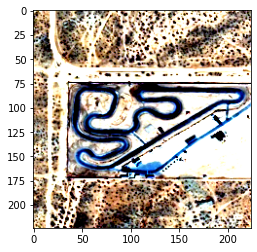

In [16]:
plt.imshow(einops.rearrange(x[0], 'c h w -> h w c'))

## Eval

In [33]:
all_y_pred, all_y_true, all_metadata = [], [], []
with torch.no_grad():
    for x, y_true, metadata in tqdm.tqdm(test_loader):
        y_pred = model(x.cuda())
        all_y_pred.append(y_pred.cpu())
        all_y_true.append(y_true.cpu())
        all_metadata.append(metadata)
        # break
all_y_pred = torch.cat(all_y_pred, axis=0)
all_y_true = torch.cat(all_y_true, axis=0)
all_metadata = torch.cat(all_metadata, axis=0)

100%|██████████| 1382/1382 [02:51<00:00,  8.04it/s]


In [34]:
print(dataset.eval(torch.argmax(all_y_pred, axis=1), all_y_true, all_metadata)[-1])

Average acc: 0.533
  year = 2016  [n =  15959]:	acc = 0.556
  year = 2017  [n =   6149]:	acc = 0.473
Worst-group acc: 0.473
  region = Asia  [n =   4963]:	acc = 0.548
  region = Europe  [n =   5858]:	acc = 0.561
  region = Africa  [n =   2593]:	acc = 0.314
  region = Americas  [n =   8024]:	acc = 0.568
  region = Oceania  [n =    666]:	acc = 0.584
Worst-group acc: 0.314



## DFR-Val

In [17]:
def get_embeddings(model, loader):
    all_embeddings, all_y_true, all_metadata = [], [], []
    with torch.no_grad():
        for x, y_true, metadata in tqdm.tqdm(loader):
            embeddings = model(x.cuda())
            all_embeddings.append(embeddings.cpu())
            all_y_true.append(y_true.cpu())
            all_metadata.append(metadata)
            # break
    all_embeddings = torch.cat(all_embeddings, axis=0)
    all_y_true = torch.cat(all_y_true, axis=0)
    all_metadata = torch.cat(all_metadata, axis=0)
    return all_embeddings, all_y_true, all_metadata

In [32]:
import sys
sys.path.append('../')
from dfr import dfr_tune, dfr_run, dfr_tune_and_run, dfr_predict

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# val_loader = get_eval_loader("standard", val_data, batch_size=16)
# test_loader = get_eval_loader("standard", test_data, batch_size=16)

In [19]:
model.classifier = torch.nn.Identity(model.classifier.in_features)
model.eval();

In [20]:
reweighting_embeddings, reweighting_y_true, reweighting_metadata = get_embeddings(model, reweighting_loader)
val_embeddings, val_y_true, val_metadata = get_embeddings(model, val_loader)
test_embeddings, test_y_true, test_metadata = get_embeddings(model, test_loader)

100%|██████████| 691/691 [02:31<00:00,  4.55it/s]


### Tune hypers on original validation

In [38]:
import copy

In [33]:
C_OPTIONS = [1., 0.3, 0.1, 0.07, 0.03, 0.01, 0.003]
THRESHOLD_OPTIONS = [0.]#[-0.15, -0.1, -0.05, 0., 0.05, 0.1, 0.15]
REG = "l1"

In [45]:
def dfr_tune_on_val(
        eval_fn, reweighting_embeddings, reweighting_y_true, reweighting_groups, 
        val_embeddings,
        verbose=False, preprocess=True
):
    all_results = {}
    best_wga = 0
    for c in C_OPTIONS:
        logreg, scaler = dfr_run(
                reweighting_embeddings, reweighting_y_true, reweighting_groups,
                num_retrains=10, preprocess=preprocess, reg=REG, verbose=verbose, c=c)
        for threshold in THRESHOLD_OPTIONS:
            shifted_logreg = copy.deepcopy(logreg)
            shifted_logreg.intercept_ += threshold
            dfr_val_predictions = torch.from_numpy(dfr_predict(val_embeddings, shifted_logreg, scaler))
            wga = eval_fn(dfr_val_predictions)
            all_results[c, threshold] = wga
            if wga > best_wga:
                best_logreg = copy.deepcopy(shifted_logreg)
                best_wga = wga
                if verbose:
                    print('new best wga:', best_wga)
            if verbose:
                print(f'c={c}, t={threshold}: {wga}')
    if verbose:
        print(all_results)
    return best_logreg, scaler

In [46]:
reweighting_groups = reweighting_metadata[:, 0]
mask = reweighting_groups != 5
reweighting_embeddings, reweighting_y_true, reweighting_metadata, reweighting_groups = (
    reweighting_embeddings[mask], reweighting_y_true[mask], reweighting_metadata[mask], reweighting_groups[mask])

In [48]:
eval_fn = lambda preds: test_data.eval(preds, val_y_true, val_metadata)[0]['acc_worst_region']
logreg, scaler = dfr_tune_on_val(
        eval_fn, reweighting_embeddings, reweighting_y_true, reweighting_groups, 
        val_embeddings, verbose=True, preprocess=True)

Training model 0/10, group counts: [304 304 304 304 304]
Training model 1/10, group counts: [304 304 304 304 304]
Training model 2/10, group counts: [304 304 304 304 304]
Training model 3/10, group counts: [304 304 304 304 304]
Training model 4/10, group counts: [304 304 304 304 304]
Training model 5/10, group counts: [304 304 304 304 304]
Training model 6/10, group counts: [304 304 304 304 304]
Training model 7/10, group counts: [304 304 304 304 304]
Training model 8/10, group counts: [304 304 304 304 304]
Training model 9/10, group counts: [304 304 304 304 304]
new best wga: 0.4956413507461548
c=1.0, t=0.0: 0.4956413507461548
Training model 0/10, group counts: [304 304 304 304 304]
Training model 1/10, group counts: [304 304 304 304 304]
Training model 2/10, group counts: [304 304 304 304 304]
Training model 3/10, group counts: [304 304 304 304 304]
Training model 4/10, group counts: [304 304 304 304 304]
Training model 5/10, group counts: [304 304 304 304 304]
Training model 6/10, g

In [49]:
val_preds = torch.from_numpy(dfr_predict(val_embeddings, logreg, scaler))
test_preds = torch.from_numpy(dfr_predict(test_embeddings, logreg, scaler))

In [52]:
print(dataset.eval(val_preds, val_y_true, val_metadata)[-1])

Average acc: 0.583
  year = 2013  [n =   3850]:	acc = 0.594
  year = 2014  [n =   6192]:	acc = 0.611
  year = 2015  [n =   9873]:	acc = 0.561
Worst-group acc: 0.561
  region = Asia  [n =   4121]:	acc = 0.555
  region = Europe  [n =   7732]:	acc = 0.616
  region = Africa  [n =    803]:	acc = 0.496
  region = Americas  [n =   6562]:	acc = 0.563
  region = Oceania  [n =    693]:	acc = 0.664
Worst-group acc: 0.496



In [50]:
print(dataset.eval(test_preds, test_y_true, test_metadata)[-1])

Average acc: 0.517
  year = 2016  [n =  15959]:	acc = 0.538
  year = 2017  [n =   6149]:	acc = 0.462
Worst-group acc: 0.462
  region = Asia  [n =   4963]:	acc = 0.533
  region = Europe  [n =   5858]:	acc = 0.536
  region = Africa  [n =   2593]:	acc = 0.346
  region = Americas  [n =   8024]:	acc = 0.544
  region = Oceania  [n =    666]:	acc = 0.568
Worst-group acc: 0.346



### Validation from the dataset

In [34]:
val_data.metadata_fields

['region', 'year', 'y', 'from_source_domain']

In [40]:
mask = val_metadata[:, 0] != 5
val_embeddings, val_y_true, val_metadata = val_embeddings[mask], val_y_true[mask], val_metadata[mask]

val_groups = val_metadata[:, 0]
test_groups = test_metadata[:, 0]

In [45]:
logreg, scaler = dfr_tune_and_run(val_embeddings, val_y_true, val_groups, verbose=True)

1.0: [0.67979741 0.64168552 0.69655172 0.70155039 0.74691358]
0.7: [0.66516601 0.63433258 0.73103448 0.69089147 0.7654321 ]
0.3: [0.66460326 0.62245475 0.68965517 0.69767442 0.7654321 ]
0.1: [0.59763647 0.52262443 0.66206897 0.61143411 0.74074074]
0.07: [0.49746764 0.46521493 0.60689655 0.52616279 0.66049383]
0.03: [0.24648284 0.25028281 0.47586207 0.28585271 0.41975309]
0.01: [0.06584131 0.03563348 0.33103448 0.08187984 0.04320988]
Training model 0/10, group counts: [304 304 304 304 304]
Training model 1/10, group counts: [304 304 304 304 304]
Training model 2/10, group counts: [304 304 304 304 304]
Training model 3/10, group counts: [304 304 304 304 304]
Training model 4/10, group counts: [304 304 304 304 304]
Training model 5/10, group counts: [304 304 304 304 304]
Training model 6/10, group counts: [304 304 304 304 304]
Training model 7/10, group counts: [304 304 304 304 304]
Training model 8/10, group counts: [304 304 304 304 304]
Training model 9/10, group counts: [304 304 304 30

In [46]:
val_preds = torch.from_numpy(dfr_predict(val_embeddings, logreg, scaler))
test_preds = torch.from_numpy(dfr_predict(test_embeddings, logreg, scaler))

In [47]:
print(dataset.eval(test_preds, test_y_true, test_metadata)[-1])

Average acc: 0.516
  year = 2016  [n =  15959]:	acc = 0.536
  year = 2017  [n =   6149]:	acc = 0.463
Worst-group acc: 0.463
  region = Asia  [n =   4963]:	acc = 0.536
  region = Europe  [n =   5858]:	acc = 0.536
  region = Africa  [n =   2593]:	acc = 0.333
  region = Americas  [n =   8024]:	acc = 0.544
  region = Oceania  [n =    666]:	acc = 0.562
Worst-group acc: 0.333



### OOD Validation

In [49]:
val_data = dataset.get_subset(
    "val", transform=transform
)
val_loader = get_eval_loader("standard", val_data, batch_size=16)

In [50]:
val_embeddings, val_y_true, val_metadata = get_embeddings(model, val_loader)

100%|██████████| 1245/1245 [02:04<00:00, 10.01it/s]


In [51]:
mask = val_metadata[:, 0] != 5
val_embeddings, val_y_true, val_metadata = val_embeddings[mask], val_y_true[mask], val_metadata[mask]

val_groups = val_metadata[:, 0]
test_groups = test_metadata[:, 0]

In [52]:
logreg, scaler = dfr_tune_and_run(val_embeddings, val_y_true, val_groups, verbose=True)

1.0: [0.5456292  0.56017039 0.69156627 0.52509769 0.82666667]
0.7: [0.55091258 0.57534611 0.66987952 0.52359483 0.79466667]
0.3: [0.55043228 0.56602769 0.67228916 0.52780283 0.768     ]
0.1: [0.52305476 0.56895634 0.64578313 0.51577998 0.71466667]
0.07: [0.493756   0.5157082  0.61204819 0.47520289 0.69866667]
0.03: [0.3184438  0.3828541  0.42409639 0.32401563 0.57866667]
0.01: [0.117195   0.26038339 0.28674699 0.16892095 0.23466667]
Training model 0/10, group counts: [693 693 693 693 693]
Training model 1/10, group counts: [693 693 693 693 693]
Training model 2/10, group counts: [693 693 693 693 693]
Training model 3/10, group counts: [693 693 693 693 693]
Training model 4/10, group counts: [693 693 693 693 693]
Training model 5/10, group counts: [693 693 693 693 693]
Training model 6/10, group counts: [693 693 693 693 693]
Training model 7/10, group counts: [693 693 693 693 693]
Training model 8/10, group counts: [693 693 693 693 693]
Training model 9/10, group counts: [693 693 693 69

In [53]:
val_preds = torch.from_numpy(dfr_predict(val_embeddings, logreg, scaler))
test_preds = torch.from_numpy(dfr_predict(test_embeddings, logreg, scaler))

In [54]:
print(dataset.eval(test_preds, test_y_true, test_metadata)[-1])

Average acc: 0.536
  year = 2016  [n =  15959]:	acc = 0.552
  year = 2017  [n =   6149]:	acc = 0.493
Worst-group acc: 0.493
  region = Asia  [n =   4963]:	acc = 0.558
  region = Europe  [n =   5858]:	acc = 0.536
  region = Africa  [n =   2593]:	acc = 0.437
  region = Americas  [n =   8024]:	acc = 0.548
  region = Oceania  [n =    666]:	acc = 0.605
Worst-group acc: 0.437



In [43]:
dataset.metadata_fields

['region', 'year', 'y', 'from_source_domain']

In [46]:
torch.bincount(val_metadata[:, 0])

tensor([4121, 7732,  803, 6562,  693,    4])

In [48]:
mask = val_metadata[:, 0] != 5
val_embeddings, val_y_true, val_metadata = val_embeddings[mask], val_y_true[mask], val_metadata[mask]

In [31]:
np.bincount(val_y_true)

array([  38,  200,  143,  258,   59,  116,  340,   38,  188,  196,  218,
        962,  153,  104,  421,  218,  150,  268,  101,  250,  270,  176,
        390,  197,  283,   76,  150,   33,  133,  500,  467,    4,  258,
        153,  220,  768,  858,  211,   53,  177,  227,  274, 1272,  252,
        134,   29,  283,  265,  289,  150,    5,  232,  178,  216,  386,
        180,  338,  237,  221,  212,  143,   52])

In [50]:
val_groups = val_metadata[:, 0]
test_groups = test_metadata[:, 0]

In [51]:
logreg, scaler = dfr_tune_and_run(val_embeddings, val_y_true, val_groups, verbose=True)

1.0: [0.55146003 0.57466421 0.65931373 0.52569528 0.83569405]
0.7: [0.53662039 0.57150382 0.66666667 0.53143894 0.81303116]
0.3: [0.5586405  0.57387411 0.63970588 0.54353083 0.78470255]
0.1: [0.54571565 0.55280485 0.57352941 0.52932285 0.69688385]
0.07: [0.51507899 0.52357124 0.53431373 0.47914148 0.69688385]
0.03: [0.36045955 0.38872794 0.43137255 0.33524788 0.57223796]
0.01: [0.11393011 0.25783513 0.29166667 0.17775091 0.20963173]
Training model 0/10, group counts: [693 693 693 693 693]
Training model 1/10, group counts: [693 693 693 693 693]
Training model 2/10, group counts: [693 693 693 693 693]
Training model 3/10, group counts: [693 693 693 693 693]
Training model 4/10, group counts: [693 693 693 693 693]
Training model 5/10, group counts: [693 693 693 693 693]
Training model 6/10, group counts: [693 693 693 693 693]
Training model 7/10, group counts: [693 693 693 693 693]
Training model 8/10, group counts: [693 693 693 693 693]
Training model 9/10, group counts: [693 693 693 69

In [52]:
val_preds = torch.from_numpy(dfr_predict(val_embeddings, logreg, scaler))
test_preds = torch.from_numpy(dfr_predict(test_embeddings, logreg, scaler))

In [54]:
print(dataset.eval(test_preds, test_y_true, test_metadata)[-1])

Average acc: 0.537
  year = 2016  [n =  15959]:	acc = 0.554
  year = 2017  [n =   6149]:	acc = 0.493
Worst-group acc: 0.493
  region = Asia  [n =   4963]:	acc = 0.558
  region = Europe  [n =   5858]:	acc = 0.544
  region = Africa  [n =   2593]:	acc = 0.427
  region = Americas  [n =   8024]:	acc = 0.547
  region = Oceania  [n =    666]:	acc = 0.614
Worst-group acc: 0.427



In [55]:
[(test_preds == test_y_true)[test_groups == g].float().mean() for g in range(4)]

[tensor(0.5579), tensor(0.5437), tensor(0.4265), tensor(0.5472)]

### ID Validation

In [57]:
id_val_data = dataset.get_subset(
    "id_val", transform=transform)
id_val_loader = get_eval_loader("standard", id_val_data, batch_size=16)

In [58]:
val_embeddings, val_y_true, val_metadata = get_embeddings(model, id_val_loader)

100%|██████████| 718/718 [01:20<00:00,  8.88it/s]


In [59]:
mask = val_metadata[:, 0] != 5
val_embeddings, val_y_true, val_metadata = val_embeddings[mask], val_y_true[mask], val_metadata[mask]
val_groups = val_metadata[:, 0]

In [60]:
logreg, scaler = dfr_tune_and_run(val_embeddings, val_y_true, val_groups, verbose=True)

1.0: [0.44819985 0.39924242 0.63106796 0.44937128 0.76612903]
0.7: [0.49008082 0.42727273 0.67961165 0.475182   0.7983871 ]
0.3: [0.45848641 0.43977273 0.63106796 0.45135672 0.78225806]
0.1: [0.32255694 0.30909091 0.4368932  0.34348114 0.58870968]
0.07: [0.23144747 0.28181818 0.4368932  0.30509596 0.53225806]
0.03: [0.11756062 0.18181818 0.37864078 0.21244209 0.2983871 ]
0.01: [0.07274063 0.03977273 0.33980583 0.07279947 0.        ]
Training model 0/10, group counts: [190 190 190 190 190]
Training model 1/10, group counts: [190 190 190 190 190]
Training model 2/10, group counts: [190 190 190 190 190]
Training model 3/10, group counts: [190 190 190 190 190]
Training model 4/10, group counts: [190 190 190 190 190]
Training model 5/10, group counts: [190 190 190 190 190]
Training model 6/10, group counts: [190 190 190 190 190]
Training model 7/10, group counts: [190 190 190 190 190]
Training model 8/10, group counts: [190 190 190 190 190]
Training model 9/10, group counts: [190 190 190 19

In [61]:
val_preds = torch.from_numpy(dfr_predict(val_embeddings, logreg, scaler))
test_preds = torch.from_numpy(dfr_predict(test_embeddings, logreg, scaler))

In [62]:
print(dataset.eval(test_preds, test_y_true, test_metadata)[-1])

Average acc: 0.500
  year = 2016  [n =  15959]:	acc = 0.519
  year = 2017  [n =   6149]:	acc = 0.448
Worst-group acc: 0.448
  region = Asia  [n =   4963]:	acc = 0.534
  region = Europe  [n =   5858]:	acc = 0.515
  region = Africa  [n =   2593]:	acc = 0.307
  region = Americas  [n =   8024]:	acc = 0.523
  region = Oceania  [n =    666]:	acc = 0.581
Worst-group acc: 0.307



In [64]:
print(dataset.eval(val_preds, val_y_true, val_metadata)[-1])

Average acc: 0.630
  year = 2002  [n =    221]:	acc = 0.525
  year = 2003  [n =    294]:	acc = 0.510
  year = 2004  [n =    210]:	acc = 0.495
  year = 2005  [n =    305]:	acc = 0.541
  year = 2006  [n =    390]:	acc = 0.603
  year = 2007  [n =    159]:	acc = 0.572
  year = 2008  [n =    286]:	acc = 0.528
  year = 2009  [n =    985]:	acc = 0.578
  year = 2010  [n =   2458]:	acc = 0.640
  year = 2011  [n =   2873]:	acc = 0.669
  year = 2012  [n =   3297]:	acc = 0.653
Worst-group acc: 0.495
  region = Asia  [n =   2693]:	acc = 0.645
  region = Europe  [n =   5268]:	acc = 0.588
  region = Africa  [n =    190]:	acc = 0.974
  region = Americas  [n =   3076]:	acc = 0.642
  region = Oceania  [n =    251]:	acc = 0.944
Worst-group acc: 0.588



## Remove subset

In [69]:
train_data = dataset.get_subset(
        "train",
        frac=1.,
        transform=transform)

In [70]:
train_data.indices.size

76863